# load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import corrcoef
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.api import GLS
from numpy import cov
from scipy.stats import spearmanr

In [2]:
species = !ls ../../data/preprocessed/gex_counts_by_sample/

In [3]:
species = ['human', 'mouse', 'marmoset', 'macaque']

In [4]:
pairs_use = [('human', 'macaque'), ('human', 'marmoset'), ('human', 'mouse'), ('macaque', 'marmoset'), ('macaque', 'mouse'), ('marmoset', 'mouse')]

In [5]:
def common_index(a, b):
    '''
    finds the common indicies between two pandas dataframes
    
    args:
        a: a pandas dataframe  with some indecies in common w/ b
        b: a pandas dataframe with some indecies in common w/ a
    returns:
        a_prime : the dataframe a indexed by common elements with a
        b_prime : the dataframe b indexed by common elements with b
    '''
    a_prime = a.loc[a.index.isin(b.index)]
    b_prime = b.loc[a_prime.index]
    return a_prime, b_prime

# Calculate GLS

In [6]:
from scipy.stats import pearsonr

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
orgin = 'human'

In [9]:
path = '../../data/preprocessed/methylation_cluster_level/{}_orgin/'
tail = '{}_dmrs.tsv'

In [10]:
specie = 'human'

In [11]:
a = pd.read_csv('../../data/preprocessed/methylation_cluster_level/human_orgin/human_dmrs.tsv', sep = '\t').set_index('Unnamed: 0')

In [13]:
for orgin in species:
    path_use = path.format(orgin) + tail
    clust_measures = {specie : (pd.read_csv(path_use.format(specie),
                                        sep = '\t').set_index('Unnamed: 0') -1).abs() for specie in species}
    out_dir = '../../data/outputs/dmr_gls_results/{}_origin/'.format(orgin)
    !mkdir -p $out_dir
    print(orgin)
    for pair in pairs_use:
        spec1, spec2 = pair
        df1 = clust_measures[spec1]
        df2 = clust_measures[spec2]
        df1_ids = df1.loc[df1.isna().sum(axis=1) <= 3].index.values
        df2_ids = df2.loc[df2.isna().sum(axis=1) <= 3].index.values
        print(len(df1_ids), len(df2_ids)
        use_ids = np.intersect1d(df1_ids, df2_ids)
        df1 = df1.loc[use_ids]
        df2 = df2.loc[use_ids]
        df1, df2 = common_index(df1, df2)
        print(df1.shape, df2.shape)

        # n_neighbors.fit(df1.values)
        cov_use = (cov(df1.loc[df1.isna().sum(axis=1) == 0].values.T))
                   # + cov(df2.loc[df2.isna().sum(axis=1) == 0].values.T))/2
        cov_a = cov(df1.loc[df1.isna().sum(axis=1) ==0].values.T)
        cov_b = cov(df2.loc[df2.isna().sum(axis=1) ==0].values.T)
        n_gene = df1.shape[0]
        r_square = [None] * n_gene
        param = [None] * n_gene
        p_vals = [None] * n_gene
        t_vals = [None] * n_gene
        corr = [None] * n_gene
        corr_p = [None] * n_gene
        pear_corr =[None] * n_gene
        pear_p = [None] * n_gene
        
        nan_vals = np.logical_or((df1.isna().sum(axis=1) > 0), (df2.isna().sum(axis=1) > 0))
        for idx, nan_val in zip(range(n_gene), nan_vals):
            
            dat1 = df1.iloc[idx].values
            dat2 = df2.iloc[idx].values
            sig_use = cov_use
            if nan_val:
                use_clusts = np.invert(np.logical_or(np.isnan(dat1), np.isnan(dat2)))
                dat1 = dat1[use_clusts]
                dat2 = dat2[use_clusts]
                sig_use = sig_use[use_clusts, use_clusts]
            model = GLS(dat1, dat2,
                        sigma=sig_use)
            res = model.fit()
            r_square[idx] = res.rsquared
            p_vals[idx] = res.pvalues[0]
            param[idx] = res.params[0]
            t_vals[idx] = res.t_test([1]).tvalue[0][0]
            # compare to correlation
            corr_, corr_p_ = spearmanr(df1.iloc[idx].values, 
                                       df2.iloc[idx].values, nan_policy='omit')
            corr[idx] = corr_
            corr_p[idx] = corr_p_ 
            pear_c, pear_p_ = pearsonr(dat1, 
                                       dat2)
            pear_corr[idx] = pear_c
            pear_p[idx] = pear_p_
        print(np.sum(np.isnan(p_vals)), 'na_p_vals')
        p_vals = np.nan_to_num(np.array(p_vals), nan=1)
        corr_p = np.nan_to_num(np.array(corr_p), nan=1)
        pear_p = np.nan_to_num(np.array(pear_p), nan=1)
        sig, fdr = fdrcorrection(p_vals, alpha=.05, method='n')
        sig_corr, fdr_corr = fdrcorrection(corr_p, alpha=.05, method='n')
        sig_pearson, fdr_pear = fdrcorrection(pear_p, alpha=.05, method='n')

        print(np.sum(fdr < .05), spec1, spec2)
        print(sig_corr.sum())
        df_res = pd.DataFrame(np.array([r_square, param, p_vals, t_vals, fdr, 
                                        corr, fdr_corr, pear_corr, fdr_pear, nan_vals]).T,
                            index=df1.index,
                            columns=['r_square', 'coeff', 'p_val', 't_val', 'fdr', 'corr',
                                     'fdr_corr', 'pear_corr', 'fdr_pear', 'nan_inputs'])
        print('/gls_{}_{}.tsv'.format(spec1, spec2), df_res.shape)
        df_res.to_csv(out_dir + '/gls_inverse_{}_{}.tsv'.format(spec1, spec2), sep='\t')

human
(502878, 20) (502878, 20)
90 na_p_vals
240417 human macaque
87554
/gls_human_macaque.tsv (502878, 10)
(462178, 20) (462178, 20)
80 na_p_vals
124866 human marmoset
43185
/gls_human_marmoset.tsv (462178, 10)
(418687, 20) (418687, 20)
7 na_p_vals
147844 human mouse
6477
/gls_human_mouse.tsv (418687, 10)
(425957, 20) (425957, 20)
117 na_p_vals
160044 macaque marmoset
48200
/gls_macaque_marmoset.tsv (425957, 10)
(385234, 20) (385234, 20)
55 na_p_vals
144344 macaque mouse
7879
/gls_macaque_mouse.tsv (385234, 10)
(366048, 20) (366048, 20)
50 na_p_vals
138375 marmoset mouse
9177
/gls_marmoset_mouse.tsv (366048, 10)
mouse
(436476, 20) (436476, 20)
68 na_p_vals
174268 human macaque
67115
/gls_human_macaque.tsv (436476, 10)
(422184, 20) (422184, 20)
85 na_p_vals
92520 human marmoset
34925
/gls_human_marmoset.tsv (422184, 10)
(498091, 20) (498091, 20)
31 na_p_vals
112332 human mouse
7113
/gls_human_mouse.tsv (498091, 10)
(430930, 20) (430930, 20)
95 na_p_vals
132670 macaque marmoset
35659
/g

In [26]:
species = ['human', 'mouse', 'marmoset', 'macaque']

In [30]:
all_ids = []

In [31]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [32]:
for orgin in [species[0]]:
    path_use = path.format(orgin) + tail
    clust_measures = {specie : (pd.read_csv(path_use.format(specie),
                                        sep = '\t').set_index('Unnamed: 0') -1).abs() for specie in species}
    out_dir = '../../data/outputs/dmr_gls_results/{}_origin/'.format(orgin)
    !mkdir -p $out_dir
    print(orgin)
    for pair in pairs_use:
        spec1, spec2 = pair
        df1 = clust_measures[spec1]
        df2 = clust_measures[spec2]
        df1_ids = df1.loc[df1.isna().sum(axis=1) <= 3].index.values
        df2_ids = df2.loc[df2.isna().sum(axis=1) <= 3].index.values
        print(len(df1_ids), len(df2_ids))
        use_ids = np.intersect1d(df1_ids, df2_ids)
        df1 = df1.loc[use_ids]
        df2 = df2.loc[use_ids]
        df1, df2 = common_index(df1, df2)
        all_ids.append(use_ids)
        print(df1.shape, df2.shape)

human
578995 502902
(502878, 20) (502878, 20)
578995 462202
(462178, 20) (462178, 20)
578995 418695
(418687, 20) (418687, 20)
502902 462202
(425957, 20) (425957, 20)
502902 418695
(385234, 20) (385234, 20)
462202 418695
(366048, 20) (366048, 20)


In [33]:
len(list_intersection(all_ids))

346725

# identify conserved dmrs

In [17]:
fdr_thresh = .05

In [19]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [21]:
def save_list(outfile, listlike):
    '''
    writes a file as a newline seperated list, useful for gsea, or storing information in general
    
    args:
        outfile : a file path to write a list of genes
        listline : an interatable object like a python list, or a numpy array
    
    '''
    return open(outfile, 'w').write(''.join([i + '\n' for i in listlike]).strip('\n'))

In [22]:
for orgin in species:
    cov_p = []
    cov_a = []
    cons_p = []
    cons_a = []
    for pair in pairs_use:
        spec1, spec2 = pair
        
        stats = pd.read_csv('../../data/outputs/dmr_gls_results/{}_origin/gls_inverse_{}_{}.tsv'.format(orgin, spec1, spec2), sep='\t').set_index('Unnamed: 0')
        cov_a.append(stats.index)
        cons_a.append(stats.index[stats.fdr < fdr_thresh])
        print(np.sum(stats.fdr < fdr_thresh))
        if "mouse" not in pair:
            cons_p.append(stats.index[stats.fdr < fdr_thresh])
            
            cov_p.append(stats.index[stats.fdr < fdr_thresh])
    a = list_intersection(cons_a)   
    p = list_intersection(cons_p)
    print(len(a), len(p), orgin)
    save_list('../../data/outputs/final/dmrs/{}_origin_all_conserved.txt'.format(orgin), a)
    save_list('../../data/outputs/final/dmrs/{}_origin_primate_conserved.txt'.format(orgin), np.setdiff1d(p, a))
    

240417
124866
147844
160044
144344
138375
23740 64367 human
174268
92520
112332
132670
142048
135881
15815 46336 mouse
154763
80358
91946
123211
104652
129564
14779 41015 marmoset
198609
111816
124668
152121
165882
134389
18423 52457 macaque


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal


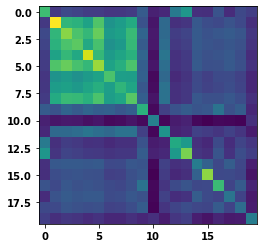

In [14]:
plt.imshow(cov_use)

Text(0.5, 1.0, 'covariance among cell types logcpm')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: normal


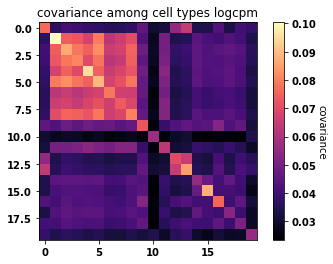

In [15]:
im = plt.imshow(cov_use, cmap ='magma')
# ticks = plt.yticks(np.arange(21), labels = clust_measures[check_specie].columns)
cbar = plt.colorbar(im)
cbar.set_label('covariance',
                       rotation=270,
                       labelpad=10)
plt.title('covariance among cell types logcpm')

In [16]:
pairs_use

[('human', 'macaque'),
 ('human', 'marmoset'),
 ('human', 'mouse'),
 ('macaque', 'marmoset'),
 ('macaque', 'mouse'),
 ('marmoset', 'mouse')]

In [17]:
species =['human', 'macaque', 'marmoset', 'mouse']

In [18]:
out_dir = '../../data/outputs/dmr_gls_results/{}_origin/'.format('human')

177726 149832
83229 81865
103884 21716
114264 75757
101625 18842
98163 17068


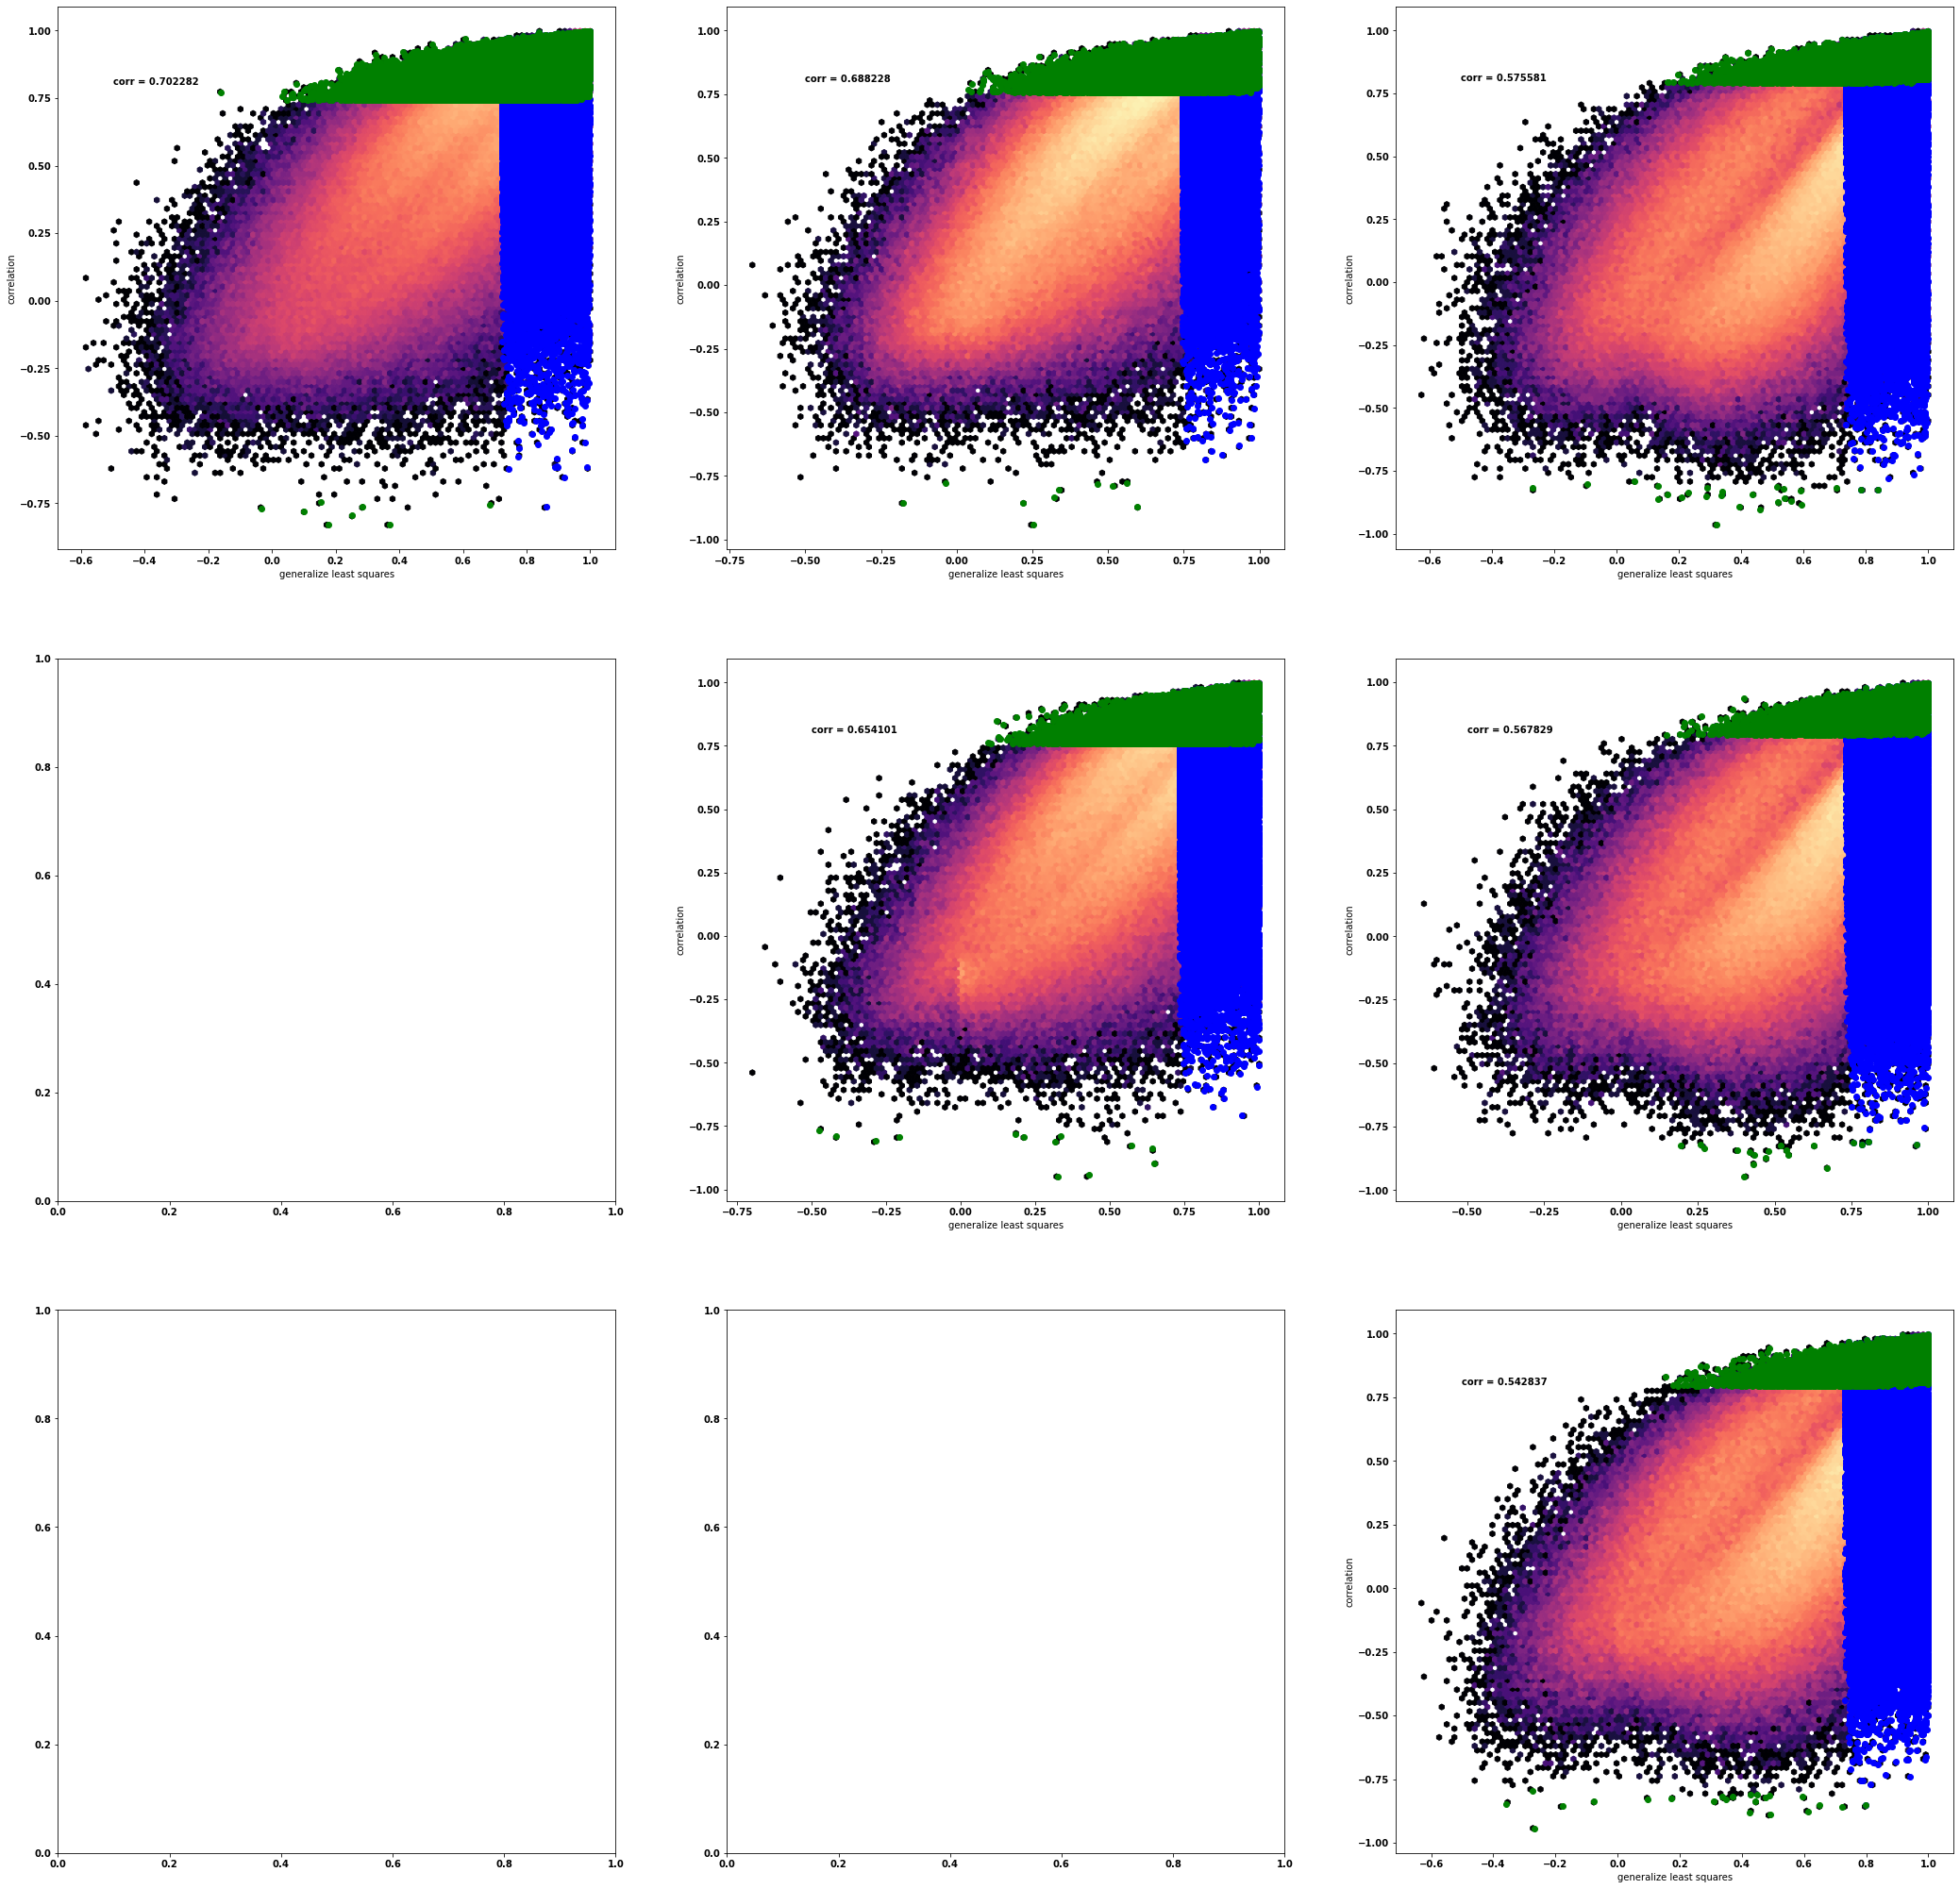

In [30]:
gene_gls = []
gene_corr = []
a_cons = []
p_cons = []

a_bg = []
p_bg = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv(out_dir + '/gls_inverse_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05/6) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_pear'] < .05/6
    gene_gls.append(stats.loc[sig_gls]['Unnamed: 0'].values)
    gene_corr.append(stats.loc[sig_corr]['Unnamed: 0'].values)
    a_cons.append(stats.loc[stats['fdr'] < .05]['Unnamed: 0'].values)
    a_bg.append(stats['Unnamed: 0'].values)
    if 'mouse' not in pair:
        p_cons.append(stats.loc[stats['fdr'] < .05]['Unnamed: 0'].values)
        p_bg.append(stats['Unnamed: 0'].values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [31]:
def list_intersection(to_intersect):
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [32]:
len(list_intersection(a_cons))

24516

In [33]:
len(list_intersection(p_cons))

65676

In [34]:
high_cons = np.unique(np.concatenate(gene_gls))

In [25]:
pair_cons= np.setdiff1d(list_intersection(p_cons), high_cons)

# Relative

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/2000
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, .8, 'corr = {:4f}'.format(r))
    
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# examine models

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

# relative

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/atac_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    x = stats['t_val']
    y = stats['coeff']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    # x = stats.t_val
    x = np.sqrt(stats['r_square']) * np.sign(stats['coeff'])
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    x = stats['pear_corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = stats['fdr'] < .05/6
    sig_corr = stats['fdr_corr'] < .05/20
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['corr']
    y = stats['corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('generalize least squares')
    ax.set_ylabel('correlation')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(-.5, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/experimental/relative_gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05) & (stats['coeff'] > 0)
    sig_corr = (stats['fdr_corr'] < .05) &(stats['coeff'] > 0)
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
lhx_check = [i.loc['LHX6'] for i in clust_measures.values()]

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('lhx_6 by species')

In [ ]:
lhx_check = [i.loc['SLC17A7'] for i in clust_measures.values()]

In [ ]:
check = pd.concat(lhx_check, axis=1)

In [ ]:
im = plt.imshow(check.values)
ticks = plt.yticks(np.arange(21), labels = relative_exp[check_specie].columns)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('logcpm',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 by species')

In [ ]:
corr_mat = np.square(np.corrcoef(check.values.T))

In [ ]:
np.fill_diagonal(corr_mat, .74)

In [ ]:
np.corrcoef(check.values.T)

In [ ]:
im = plt.imshow(corr_mat)
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('% variance explained',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
im = plt.imshow(np.corrcoef(check.values.T))
ticks = plt.yticks(np.arange(4), labels= species)
ticks = plt.xticks(np.arange(4), labels= species, rotation=90)
cbar = plt.colorbar(im)
cbar.set_label('Pearson correlation',
                       rotation=270,
                       labelpad=10)
plt.title('SLC17A7 similarity')

In [ ]:
stats_z.loc[stats_z.t_val> 15]

In [ ]:
stats.loc[(stats_z.t_val> 10) & (stats.t_val < 10)]

In [ ]:
stats.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats.human_gene == 'LHX6']

In [ ]:
stats_z.loc[stats_z.fdr < .05/6].t_val.min()

In [ ]:
stats.loc[stats.fdr < .05/6].t_val.min()

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['t_val']
    y = stats['t_val']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
gene_gls = []
gene_corr = []
fig, axs = plt.subplots(3, 3, figsize=(4*9, 4*9))
# param_use = 
pairs = []
for specie in species[:-1]:
    for specie_2 in species[1:]:
        pairs.append((specie, specie_2))

max_t_stat = 20

axs = axs.flatten()
idx = 0
for ax, pair in zip(axs, pairs):
    if pair not in pairs_use:
        continue
    spec1, spec2 = pair
    stats = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    stats_z = pd.read_csv('../../data/outputs/gex_gls_results/relative/gls_z_{}_{}.tsv'.format(spec1, spec2), sep='\t')
    
    # x = stats.t_val
    x = stats_z['pear_corr']
    y = stats['pear_corr']
    use = x < max_t_stat
    r = spearmanr(x[use], y[use], nan_policy='omit')[0]
    im = ax.hexbin(x[use], y[use], cmap='magma', bins='log')
    ax.set_xlabel('gls zscore')
    ax.set_ylabel('gls no z')
    sig_gls = (stats['fdr'] < .05/2000) & (stats['coeff'] > 0)
    sig_corr = stats['fdr_corr'] < .05
    gene_gls.append(stats.loc[sig_gls].human_gene.values)
    gene_corr.append(stats.loc[sig_corr].human_gene.values)
    ax.text(10, 1, 'corr = {:4f}'.format(r))
    
    print(np.sum(sig_gls), np.sum(sig_corr))
    # ax.scatter(x[sig_gls], y[sig_gls], c='blue')
    # ax.scatter(x[sig_corr], y[sig_corr], c='green')    

In [ ]:
def list_intersection(to_intersect):
    '''
    get elements in the intersection of a group of lists/arrays
    
    args:
        to_intersect : a list of lists or other listlike objects
    returns:
        common : a numpy array of all elements common in all lists
    
    '''
    common = to_intersect[0]
    for item in to_intersect[1:]:
        common = np.intersect1d(common, item)
    return common

In [ ]:
primate = list_intersection(gene_gls[:3])

In [ ]:
primate_corr = list_intersection(gene_corr[:3])

In [ ]:
len(primate),len(primate_corr)

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr))

In [ ]:
x = [i.loc[list_intersection(gene_gls)].mean(axis=1) for i in clust_measures.values()]

In [ ]:
y = [i.loc[~i.index.isin(list_intersection(gene_gls))].mean(axis=1) for i in clust_measures.values()]

In [ ]:
len(list_intersection(gene_gls)), len(list_intersection(gene_corr)) 

In [ ]:
list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)])

In [ ]:
len(list_intersection([list_intersection(gene_gls), list_intersection(gene_corr)]))

In [ ]:
len(list_intersection(gene_gls))/10790 *  len(list_intersection(gene_corr))/10790

In [ ]:
plt.hexbin(stats['t_val'], stats['coeff'], bins='log', cmap='magma')